In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from tensorflow.keras.utils import plot_model



In [2]:
def retrieve_data(varname, filename):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [3]:
files = {
    # varname: filename
    "S&P500": "Dataset v3/SP500_combined_data_20220412.csv",
}
for file in files:
    df = retrieve_data(file, files[file])
df

,Date,SP500_Volume,SP500_relative_change_perc_1,SP500_relative_change_perc_5,SP500_relative_change_perc_10,SP500_relative_change_perc_20,SP500_relative_change_perc_50,SP500_EMA5,SP500_EMA10,SP500_EMA20,...,USDHKD_relative_change_perc_1,USDHKD_relative_change_perc_5,USDHKD_relative_change_perc_10,USDHKD_relative_change_perc_20,USDHKD_relative_change_perc_50,USDJPY_relative_change_perc_1,USDJPY_relative_change_perc_5,USDJPY_relative_change_perc_10,USDJPY_relative_change_perc_20,USDJPY_relative_change_perc_50
0,2009-07-01,0.0,0.002726,0.005099,0.001479,-0.000382,0.001847,0.001482,0.001144,0.000720,...,0.000090,0.000085,0.000081,0.000087,0.000088,0.002910,0.001785,0.000867,0.000530,-0.000260
1,2009-07-02,0.0,-0.026942,-0.004917,-0.002039,-0.002264,0.001396,-0.007993,-0.003963,-0.001914,...,0.000077,0.000083,0.000081,0.000090,0.000088,-0.007252,0.000209,-0.000608,-0.000166,-0.000370
2,2009-07-03,0.0,-0.018962,-0.004671,-0.001949,-0.002128,0.001378,-0.006912,-0.003556,-0.001750,...,0.000000,0.000062,0.000079,0.000080,0.000087,0.002087,0.001817,0.000014,-0.001221,-0.000077
3,2009-07-06,0.0,0.004976,-0.003935,-0.001680,-0.001720,0.001323,-0.003670,-0.002337,-0.001258,...,0.000077,0.000065,0.000071,0.000077,0.000088,-0.006676,-0.001599,0.000023,-0.001458,-0.000130
4,2009-07-07,0.0,-0.019553,-0.009448,-0.000902,-0.002752,0.000643,-0.008964,-0.005467,-0.003000,...,0.000077,0.000065,0.000075,0.000079,0.000090,-0.006301,-0.003047,-0.000502,-0.001230,-0.000291
5,2009-07-08,0.0,-0.002653,-0.008289,-0.001351,-0.002995,0.000713,-0.006861,-0.004956,-0.002967,...,0.000116,0.000070,0.000077,0.000079,0.000090,-0.020082,-0.007645,-0.002930,-0.002645,-0.000911
6,2009-07-09,0.0,0.001589,-0.008517,-0.001709,-0.002726,0.000729,-0.004044,-0.003766,-0.002533,...,0.000026,0.000059,0.000071,0.000071,0.000089,0.004637,-0.005267,-0.002529,-0.002067,-0.001086
7,2009-07-10,0.0,-0.001023,-0.003333,-0.004125,-0.003088,0.000317,-0.003037,-0.003267,-0.002389,...,0.000026,0.000065,0.000063,0.000075,0.000088,-0.006655,-0.007016,-0.002599,-0.002846,-0.001361
8,2009-07-13,0.0,0.024421,0.000556,-0.001689,-0.002014,0.000891,0.006116,0.001767,0.000164,...,0.000052,0.000059,0.000062,0.000070,0.000087,0.006814,-0.004318,-0.002958,-0.002088,-0.001112
9,2009-07-14,0.0,0.005629,0.005592,-0.001928,-0.000739,0.000894,0.005953,0.002469,0.000684,...,0.000026,0.000049,0.000057,0.000070,0.000086,0.005800,-0.001897,-0.002472,-0.000969,-0.000974


In [4]:
def create_classification_data(df, lookback):
    rows = []
    columns = ['Date', 'SP500_relative_change_perc_1'] # date and target
    for i in range(1, lookback + 1):
        new_columns = df.columns.tolist()[1:]
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
        
    for i, row in enumerate(df.iterrows()):
        if i > lookback:
            new_row = [row[1][0], row[1][2]]
            for x in range(1, lookback + 1):
                add_row = df.iloc[i - x].tolist()
                new_row = new_row + add_row[1:]
            rows.append(new_row)
    df2 = pd.DataFrame(rows)
    df2.columns = columns
    return df2
df = create_classification_data(df, 5)
df

,Date,SP500_relative_change_perc_1,SP500_Volume_t-1,SP500_relative_change_perc_1_t-1,SP500_relative_change_perc_5_t-1,SP500_relative_change_perc_10_t-1,SP500_relative_change_perc_20_t-1,SP500_relative_change_perc_50_t-1,SP500_EMA5_t-1,SP500_EMA10_t-1,...,USDHKD_relative_change_perc_1_t-5,USDHKD_relative_change_perc_5_t-5,USDHKD_relative_change_perc_10_t-5,USDHKD_relative_change_perc_20_t-5,USDHKD_relative_change_perc_50_t-5,USDJPY_relative_change_perc_1_t-5,USDJPY_relative_change_perc_5_t-5,USDJPY_relative_change_perc_10_t-5,USDJPY_relative_change_perc_20_t-5,USDJPY_relative_change_perc_50_t-5
0,2009-07-09,0.001589,0.0,-0.002653,-0.008289,-0.001351,-0.002995,0.000713,-0.006861,-0.004956,...,0.000077,0.000083,0.000081,0.000090,0.000088,-0.007252,0.000209,-0.000608,-0.000166,-0.000370
1,2009-07-10,-0.001023,0.0,0.001589,-0.008517,-0.001709,-0.002726,0.000729,-0.004044,-0.003766,...,0.000000,0.000062,0.000079,0.000080,0.000087,0.002087,0.001817,0.000014,-0.001221,-0.000077
2,2009-07-13,0.024421,0.0,-0.001023,-0.003333,-0.004125,-0.003088,0.000317,-0.003037,-0.003267,...,0.000077,0.000065,0.000071,0.000077,0.000088,-0.006676,-0.001599,0.000023,-0.001458,-0.000130
3,2009-07-14,0.005629,0.0,0.024421,0.000556,-0.001689,-0.002014,0.000891,0.006116,0.001767,...,0.000077,0.000065,0.000075,0.000079,0.000090,-0.006301,-0.003047,-0.000502,-0.001230,-0.000291
4,2009-07-15,0.024754,0.0,0.005629,0.005592,-0.001928,-0.000739,0.000894,0.005953,0.002469,...,0.000116,0.000070,0.000077,0.000079,0.000090,-0.020082,-0.007645,-0.002930,-0.002645,-0.000911
5,2009-07-16,0.011364,0.0,0.024754,0.011074,0.001392,0.001235,0.000752,0.012220,0.006521,...,0.000026,0.000059,0.000071,0.000071,0.000089,0.004637,-0.005267,-0.002529,-0.002067,-0.001086
6,2009-07-17,-0.000191,0.0,0.011364,0.013029,0.002256,0.001868,0.001030,0.011935,0.007401,...,0.000026,0.000065,0.000063,0.000075,0.000088,-0.006655,-0.007016,-0.002599,-0.002846,-0.001361
7,2009-07-20,0.009617,0.0,-0.000191,0.013195,0.004931,0.001446,0.000681,0.007893,0.006021,...,0.000052,0.000059,0.000062,0.000070,0.000087,0.006814,-0.004318,-0.002958,-0.002088,-0.001112
8,2009-07-21,0.002742,0.0,0.009617,0.010234,0.005395,0.001858,0.001139,0.008467,0.006675,...,0.000026,0.000049,0.000057,0.000070,0.000086,0.005800,-0.001897,-0.002472,-0.000969,-0.000974
9,2009-07-22,0.000703,0.0,0.002742,0.009657,0.007625,0.003361,0.000749,0.006559,0.005960,...,0.000039,0.000034,0.000052,0.000066,0.000086,0.005874,0.003294,-0.002176,-0.000654,-0.000838


In [5]:
def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year != year_val]
        train = train[train['Date'].dt.year != year_test]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = df.head(len(val) - len(test))
    
    y_train = train['SP500_relative_change_perc_1']
    x_train = train.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_val = val['SP500_relative_change_perc_1']
    x_val = val.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_test = test['SP500_relative_change_perc_1']
    x_test = test.drop(['SP500_relative_change_perc_1'], axis=1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(df, 2018, 2019)

In [6]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x = x.drop(["Date"], axis=1)
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)

In [7]:
x_train_scaled

,SP500_Volume_t-1,SP500_relative_change_perc_1_t-1,SP500_relative_change_perc_5_t-1,SP500_relative_change_perc_10_t-1,SP500_relative_change_perc_20_t-1,SP500_relative_change_perc_50_t-1,SP500_EMA5_t-1,SP500_EMA10_t-1,SP500_EMA20_t-1,SP500_EMA50_t-1,...,USDHKD_relative_change_perc_1_t-5,USDHKD_relative_change_perc_5_t-5,USDHKD_relative_change_perc_10_t-5,USDHKD_relative_change_perc_20_t-5,USDHKD_relative_change_perc_50_t-5,USDJPY_relative_change_perc_1_t-5,USDJPY_relative_change_perc_5_t-5,USDJPY_relative_change_perc_10_t-5,USDJPY_relative_change_perc_20_t-5,USDJPY_relative_change_perc_50_t-5
0,0.0,0.561889,0.427321,0.563980,0.350535,0.559942,0.513806,0.537759,0.520318,0.565127,...,0.557843,0.368117,0.321999,0.374002,0.525830,0.410756,0.426093,0.424514,0.426833,0.350366
1,0.0,0.599555,0.422117,0.551314,0.368186,0.561975,0.573467,0.577778,0.543598,0.574288,...,0.545130,0.359099,0.320057,0.359175,0.521567,0.539241,0.494554,0.468826,0.315413,0.409878
2,0.0,0.576368,0.540717,0.465772,0.344418,0.509094,0.594802,0.594553,0.551318,0.571855,...,0.557842,0.360226,0.314233,0.354542,0.524409,0.418679,0.349100,0.469458,0.290318,0.399132
3,0.0,0.802293,0.629692,0.552011,0.414827,0.582790,0.788691,0.763868,0.688323,0.678991,...,0.557843,0.360226,0.317145,0.358250,0.529383,0.423841,0.287466,0.432056,0.314428,0.366378
4,0.0,0.635427,0.744915,0.543571,0.498400,0.583178,0.785251,0.787481,0.716248,0.701070,...,0.564198,0.362480,0.319086,0.357324,0.531514,0.234252,0.091663,0.259193,0.164957,0.240646
5,0.0,0.805251,0.870325,0.661123,0.627780,0.564899,0.918009,0.923756,0.839248,0.804572,...,0.549367,0.357971,0.314232,0.346204,0.528672,0.574320,0.192915,0.287745,0.226023,0.204963
6,0.0,0.686350,0.915053,0.691707,0.669260,0.600555,0.911959,0.953368,0.882105,0.846401,...,0.549367,0.360225,0.308408,0.351764,0.525119,0.418971,0.118463,0.282736,0.143752,0.149181
7,0.0,0.583750,0.918857,0.786425,0.641613,0.555859,0.826334,0.906937,0.861834,0.836873,...,0.553604,0.357971,0.307437,0.345276,0.522987,0.604264,0.233347,0.257178,0.223756,0.199731
8,0.0,0.670844,0.851118,0.802858,0.668605,0.614524,0.838511,0.928928,0.893616,0.869922,...,0.549367,0.353462,0.303553,0.344349,0.520855,0.590320,0.336404,0.291809,0.342063,0.227806
9,0.0,0.609794,0.837908,0.881797,0.767144,0.564562,0.798079,0.904877,0.887237,0.872091,...,0.551486,0.346699,0.299670,0.339715,0.518724,0.591338,0.557453,0.312916,0.375296,0.255365


Epoch 1/10
220/220 [==============================] - 17s 71ms/step - loss: 0.1294 - val_loss: 0.0782
Epoch 2/10
220/220 [==============================] - 13s 60ms/step - loss: 0.0307 - val_loss: 0.0672
Epoch 3/10
220/220 [==============================] - 12s 56ms/step - loss: 0.0253 - val_loss: 0.0494
Epoch 4/10
220/220 [==============================] - 12s 55ms/step - loss: 0.0239 - val_loss: 0.0447
Epoch 5/10
220/220 [==============================] - 14s 64ms/step - loss: 0.0186 - val_loss: 0.0455
Epoch 6/10
220/220 [==============================] - 14s 62ms/step - loss: 0.0149 - val_loss: 0.0441
Epoch 7/10
220/220 [==============================] - 12s 56ms/step - loss: 0.0150 - val_loss: 0.0425
Epoch 8/10
220/220 [==============================] - 14s 62ms/step - loss: 0.0129 - val_loss: 0.0467
Epoch 9/10
220/220 [==============================] - 13s 60ms/step - loss: 0.0127 - val_loss: 0.0413
Epoch 10/10
220/220 [==============================] - 12s 56ms/step - loss: 0.012

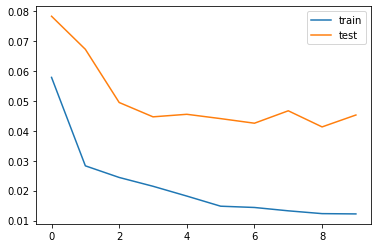

In [34]:

# https://machinelearningmastery.com/autoencoder-for-classification/

# LSTM or CNN layers are not required becuase we are no longer modelling time series, we have a window of 10 days

x_train = x_train_scaled
x_val = x_val_scaled

input_shape = x_train.shape[1]
encoding_shape = round(float(input_shape) / 3)

visible = Input(shape=(input_shape,))

# encoder layer 1
# encoder = Dense(input_shape * 3)(visible)
# encoder = BatchNormalization()(encoder)
# encoder = LeakyReLU()(encoder)
# encoder layer 1
encoder = Dense(input_shape * 2)(visible)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
# encoder layer 2
encoder = Dense(input_shape)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

# encoded layer
encoding = Dense(round(encoding_shape))(encoder)

# decoder layer 1
decoder = Dense(input_shape)(encoding)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder layer 2
decoder = Dense(input_shape * 2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder = Dense(input_shape * 3)(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = LeakyReLU()(decoder)

# output layer
output = Dense(input_shape, activation='linear')(decoder)


model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

history = model.fit(x_train, x_train, 
                    epochs=10, batch_size=12, # verbose=2, 
                    validation_data=(x_val, x_val))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

display(history)